## Week 6 Homework

---

### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Args: 
#        mu      : location - True mean Data Model
#        sigma   : Scale - True Std Data Model
#        df      : DGF - True DGF Data Model
#        mu_0    : Location - Normal mu Prior
#        tau_0   : Percision - Normal mu Prior 
#        sigma_0 : Scale - Half-Normal sigma Prior

# Parameter Specification:
n, C, G = 100, 2, 5000
mu, sigma, df = 0, 2, 15
mu_0, tau_0, sigma_0 = 0.1, 0.6, 3 
accept_mu, accept_sigma, accept_df = 0, 0, 0

# Data Model:
data = stats.t(df, loc = mu, scale = sigma).rvs(n)

# Prior Specifications: 
mu_prior = stats.norm(loc = mu_0, scale = 1/np.sqrt(tau_0))     # Normal mu Prior
sigma_prior = stats.halfnorm(scale = sigma_0)                   # Half-Normal Sigma Prior
                                                                
df_support = np.arange(1, 101)                                  
df_pmf = np.full_like(df_support, 1/100, dtype=float)           
df_prior = stats.rv_discrete(name='df_prior', 
                            values=(df_support, df_pmf))       # Discrete Uniform df Prior

# Full Conditional Target Distribution: mu
mu_posterior = lambda mu_: np.prod(stats.t(df, loc = mu_, scale = sigma).pdf(data)) * mu_prior.pdf(mu_)

# Full Conditional Target Distribution: sigma
sigma_posterior = lambda sigma_: np.prod(stats.t(df, loc = mu, scale = sigma_).pdf(data)) * sigma_prior.pdf(sigma_)
                                 
# Full Conditional Target Distribution: df
df_posterior = lambda df_: np.prod(stats.t(df_, loc = mu, scale = sigma).pdf(data)) * df_prior.pmf(df_)

# Ambient Space Posterior Samples
mu_a, sigma_a, df_a = np.zeros([C, G]), np.zeros([C, G]), np.zeros([C, G])
mu_a[:, 0], sigma_a[:, 0], df_a[:, 0] = -0.1, 2.5, 6

for c in range(C):
    for g in range(1, G):
        # Proposal Distribution: mu 
        mu_proposal = mu_prior; mu_tilde = mu_prior.rvs()  
        
        # Acceptance Probability: On Log scale
        numerator_mu = np.log(mu_posterior(mu_tilde)) + np.log(mu_proposal.pdf(mu_a[c, g-1]))
        denominator_mu = np.log(mu_posterior(mu_a[c, g-1])) + np.log(mu_proposal.pdf(mu_tilde))
        
        mhap_mu = numerator_mu - denominator_mu
        
        # Updated Values: mu
        if np.log(stats.uniform.rvs()) < min(np.log(1), mhap_mu):
            mu_a[c, g] = mu_tilde; accept_mu += 1
        else:
            mu_a[c, g] =  mu_a[c, g-1]
    
        # Proposal Distribution: sigma 
        sigma_proposal = sigma_prior; sigma_tilde = sigma_proposal.rvs()
        
        # Acceptance Probability: On Log scale
        numerator_sigma = np.log(sigma_posterior(sigma_tilde)) + np.log(sigma_proposal.pdf(sigma_a[c, g-1]))
        denominator_sigma = np.log(sigma_posterior(sigma_a[c, g-1])) + np.log(sigma_proposal.pdf(sigma_tilde))
        
        mhap_sigma = (numerator_sigma - denominator_sigma)
        
        # Updated Values: sigma
        if np.log(stats.uniform.rvs()) < min(np.log(1), mhap_sigma):
            sigma_a[c, g] = sigma_tilde; accept_sigma += 1
        else:
            sigma_a[c, g] =  sigma_a[c, g-1]
        
        # Proposal Distribution: df
        df_proposal = df_prior; df_tilde = df_proposal.rvs()
        
        # Acceptance Probability: On Log scale
        numerator_df = np.log(df_posterior(df_tilde)) + np.log(df_proposal.pmf(df_a[c, g-1]))
        denominator_df = np.log(df_posterior(df_a[c, g-1])) + np.log(df_proposal.pmf(df_tilde))
        
        mhap_df = (numerator_sigma - denominator_sigma)
        
        # Updated Values: df
        if np.log(stats.uniform.rvs()) < min(np.log(1), mhap_df):
            df_a[c, g] = df_tilde; accept_df += 1
        else:
            df_a[c, g] =  df_a[c, g-1]
          

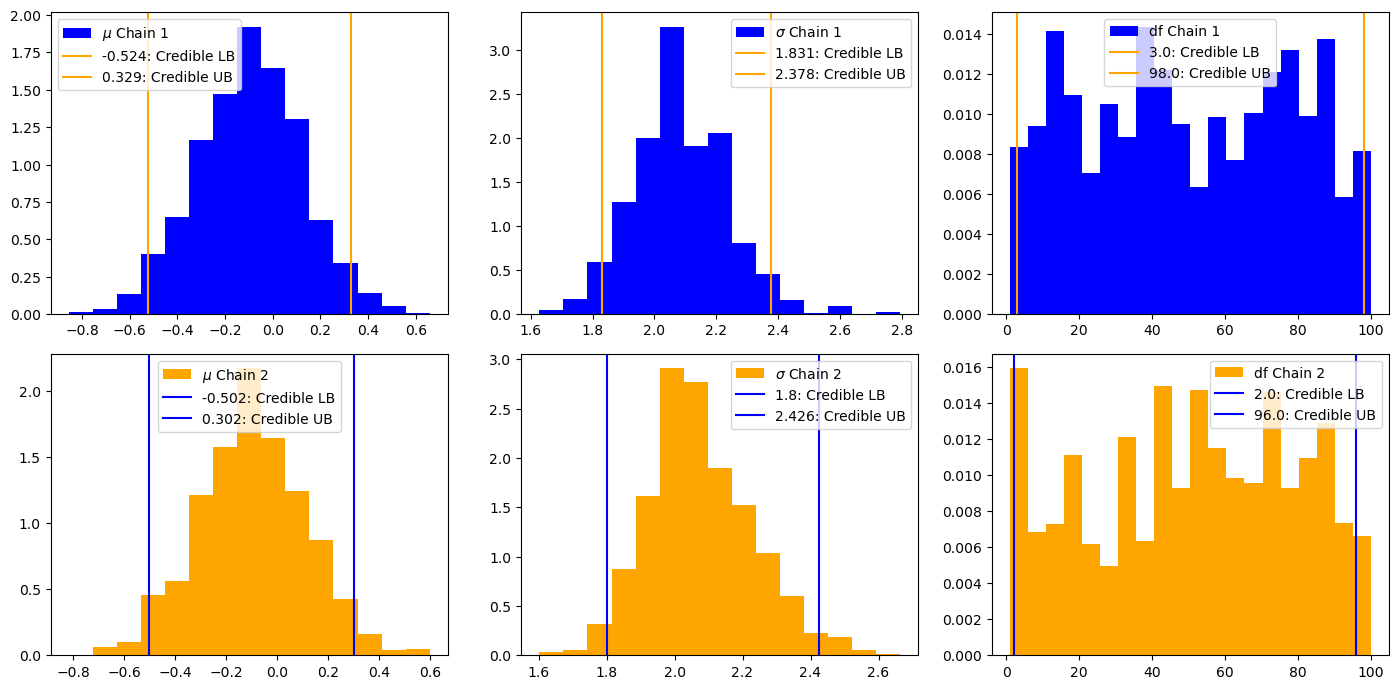

In [3]:
# Plotting 2 histograms for each chain of Mu, Sigma, and df:
fig,ax = plt.subplots(2, 3, figsize=(14,7))

# Mu histograms
ax[0][0].hist(mu_a[0, :], bins = 15, density = True, color='blue', label="$\\mu$ Chain 1")
c_1 = np.quantile(mu_a[0, :], [0.025, 0.975]).tolist()
ax[0][0].axvline(x=c_1[0], color='orange', label = f'{round(c_1[0], 3)}: Credible LB')
ax[0][0].axvline(x=c_1[1], color='orange', label = f'{round(c_1[1], 3)}: Credible UB')

ax[1][0].hist(mu_a[1, :], bins = 15, density = True, color='orange', label="$\\mu$ Chain 2")
c_2 = np.quantile(mu_a[1, :], [0.025, 0.975]).tolist()
ax[1][0].axvline(x=c_2[0], color='blue', label = f'{round(c_2[0], 3)}: Credible LB')
ax[1][0].axvline(x=c_2[1], color='blue', label = f'{round(c_2[1], 3)}: Credible UB')

# Sigma histograms
ax[0][1].hist(sigma_a[0, :], bins = 15, density = True, color='blue', label="$\\sigma$ Chain 1")
c_3 = np.quantile(sigma_a[0, :], [0.025, 0.975]).tolist()
ax[0][1].axvline(x=c_3[0], color='orange', label = f'{round(c_3[0], 3)}: Credible LB')
ax[0][1].axvline(x=c_3[1], color='orange', label = f'{round(c_3[1], 3)}: Credible UB')

ax[1][1].hist(sigma_a[1, :], bins = 15, density = True, color='orange', label="$\\sigma$ Chain 2")
c_4 = np.quantile(sigma_a[1, :], [0.025, 0.975]).tolist()
ax[1][1].axvline(x=c_4[0], color='blue', label = f'{round(c_4[0], 3)}: Credible LB')
ax[1][1].axvline(x=c_4[1], color='blue', label = f'{round(c_4[1], 3)}: Credible UB')

# df histograms
ax[0][2].hist(df_a[0, :], bins = 20, density = True, color='blue', label="df Chain 1")
c_5 = np.quantile(df_a[0, :], [0.025, 0.975]).tolist()
ax[0][2].axvline(x=c_5[0], color='orange', label = f'{round(c_5[0], 3)}: Credible LB')
ax[0][2].axvline(x=c_5[1], color='orange', label = f'{round(c_5[1], 3)}: Credible UB')

ax[1][2].hist(df_a[1, :], bins = 20, density = True, color='orange', label="df Chain 2")
c_6 = np.quantile(df_a[1, :], [0.025, 0.975]).tolist()
ax[1][2].axvline(x=c_6[0], color='blue', label = f'{round(c_6[0], 3)}: Credible LB')
ax[1][2].axvline(x=c_6[1], color='blue', label = f'{round(c_6[1], 3)}: Credible UB')

ax[0][0].legend(); ax[0][1].legend(); ax[0][2].legend(); ax[1][0].legend(); ax[1][1].legend(); ax[1][2].legend()
plt.tight_layout()

# print(accept_mu/3000, accept_sigma/3000, accept_df/3000 )

### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*



In [4]:
import pymc as pm
import arviz as az
import logging
_log = logging.getLogger("pymc")
_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
_log.setLevel(logging.WARNING) # 30
_log.setLevel(logging.ERROR) # 40

The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


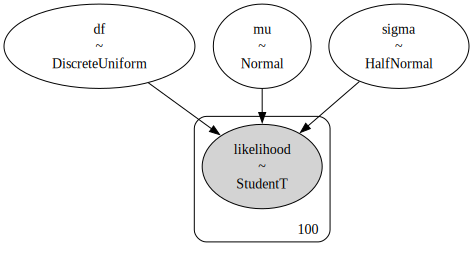

In [5]:
mu, sigma, df = 0, 2, 15
mu_0, tau_0, sigma_0 = 0.1, 0.6, 3 
data = stats.t(df, loc = mu, scale = sigma).rvs(100)

normal_halfnormal_uniform = pm.Model()

with normal_halfnormal_uniform:
    # Prior Specification: mu
    mu = pm.Normal('mu', mu = mu_0, tau = tau_0)
    
    # Prior Specification: sigma
    sigma = pm.HalfNormal("sigma", sigma = sigma_0)
    
    # Prior Specification: df
    df = pm.DiscreteUniform("df", lower=1, upper=100)
    
    # likelihood Specification
    likelihood = pm.StudentT("likelihood", nu = df, mu = mu, sigma = sigma, observed = data)
    
    sample_sizes = [100, 500, 1000, 2000, 5000, 10000, 20000]
    idata_vector = []
    
    for size in sample_sizes:
        idata_vector.append(pm.sample(draws = size, chains = 4, tune = 1000))
        
pm.model_to_graphviz(normal_halfnormal_uniform)

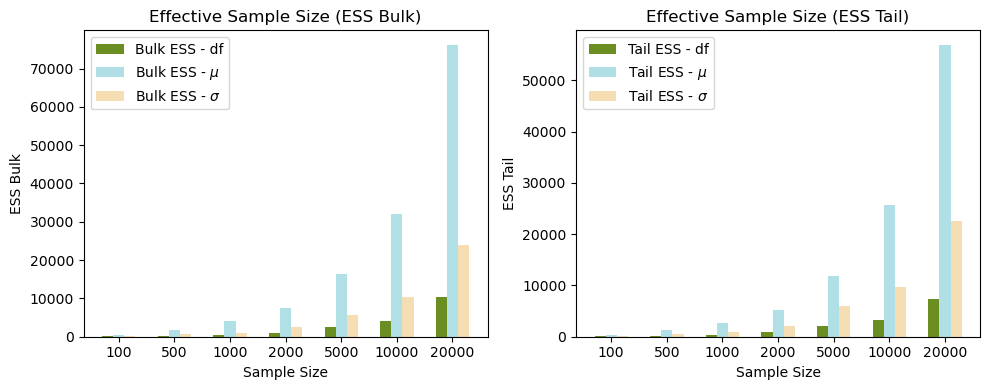

In [6]:
categories = sample_sizes
subcategories = ['df', '$\\mu$', '$\\sigma$']

ess_bulk = []
ess_tail = []
r_hat = []

for idata in idata_vector:
    ess_bulk.append([az.summary(idata)['ess_bulk']['df'], 
                     az.summary(idata)['ess_bulk']['mu'], 
                     az.summary(idata)['ess_bulk']['sigma']])
    
    ess_tail.append([az.summary(idata)['ess_tail']['df'], 
                     az.summary(idata)['ess_tail']['mu'], 
                     az.summary(idata)['ess_tail']['sigma']])
    
    r_hat.append([az.summary(idata)['r_hat']['df'], 
                  az.summary(idata)['r_hat']['mu'], 
                  az.summary(idata)['r_hat']['sigma']])


# Colors for each subcategory
colors = ['#6B8E23', '#B0E0E6', '#F5DEB3']  # Blue, Orange, Green

# Plot
x = np.arange(len(categories))  # x-axis positions for main categories
width = 0.2  # Width of each bar

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot ESS Bulk
for j in range(len(subcategories)):
    ax[0].bar(x + j * width, [d[j] for d in ess_bulk], width, label=f'Bulk ESS - {subcategories[j]}', color=colors[j])

ax[0].set_title('Effective Sample Size (ESS Bulk)')
ax[0].set_xticks(x + width)
ax[0].set_xticklabels(categories)
ax[0].legend()
ax[0].set_ylabel('ESS Bulk')
ax[0].set_xlabel('Sample Size')  # Label for the x-axis of ESS Bulk

# Plot ESS Tail
for j in range(len(subcategories)):
    ax[1].bar(x + j * width, [d[j] for d in ess_tail], width, label=f'Tail ESS - {subcategories[j]}', color=colors[j])

ax[1].set_title('Effective Sample Size (ESS Tail)')
ax[1].set_xticks(x + width)
ax[1].set_xticklabels(categories)
ax[1].legend()
ax[1].set_ylabel('ESS Tail')
ax[1].set_xlabel('Sample Size')  # Label for the x-axis of ESS Tail

# Show plot
plt.tight_layout()
plt.show()

**Inference on $v$:** The estimated mean and standard deviation (on average across all sample sizes) are 44.741 and 28.313 respectively which doesn't change dramatically with the sample size. The difference in the largest and smallest mean and standard deviation values are 10.754 and 0.432 repectively. The difference in the second largest and smallest values for the mean is 1.476. The R-hat $\hat{R}$ is quite consistent at 1 with the largest value being 1.032 (at a sample size of 100) which indicates no severe variation across chains. The $94\%$ highest density intervals is consistently at a length of 89 for all sample sizes except the sample size at 100 which is at a length of 86. 

The most notable variation across different sample sizes comes in the effective sample size which as plotted below dramatically increases as the sample size increases. At 100 samples the effective sample for $v$ is 72.787 while at 20,000 the effective sample size is 10,260.064 at the bulk level. At the tail level the same trend is also true wherein at 100 samples the effective sample is 57.313 while at 20,000 the effective sample size is 7421.077.

### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

---
### Integration Calculation:
$$ \int p(y_i|\tau_i) p(\tau_i)  d\tau_i \quad = \quad \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i \quad = \quad \left(\dfrac{\frac{v}{2}^{\frac{v}{2}}}{\sqrt{2\pi} \cdot \Gamma(\frac{v}{2})}\right) \int{\tau_i^{\frac{v+1}{2}-1}e^{-\frac{(y_i^2 + v)}{2}}}d\tau_i \\
= \quad \left(\dfrac{\frac{v}{2}^{\frac{v}{2}}}{\sqrt{2\pi} \cdot \Gamma(\frac{v}{2})}\right) \int{\dfrac{\left(\frac{y_i^2 + v}{2}\right)^{\frac{v+1}{2}} \Gamma(\frac{v+1}{2})}{\left(\frac{y_i^2 + v}{2}\right)^{\frac{v+1}{2}} \Gamma(\frac{v+1}{2})}} \tau_i^{\frac{v+1}{2}-1}e^{-\frac{(y_i^2 - v)}{2}} d\tau_i = \quad \left(\dfrac{\frac{v}{2}^{\frac{v}{2}}\cdot \Gamma(\frac{v+1}{2})}{\sqrt{2\pi} \cdot \Gamma(\frac{v}{2}) \cdot \left(\frac{y_i^2 + v}{2}\right)^{\frac{v+1}{2}}}\right) \int{\dfrac{\left(\frac{y_i^2 + v}{2}\right)^{\frac{v+1}{2}}}{\Gamma(\frac{v+1}{2})}} \tau_i^{\frac{v+1}{2}-1}e^{-\frac{(y_i^2 - v)}{2}} d\tau_i \\ 
= \quad \left(\dfrac{\frac{v}{2}^{\frac{v}{2}}\cdot \Gamma(\frac{v+1}{2})}{\sqrt{2\pi} \cdot \Gamma(\frac{v}{2}) \cdot \left(\frac{y_i^2 + v}{2}\right)^{\frac{v+1}{2}}}\right) \quad = \quad \dfrac{\frac{v}{2}^{\frac{v}{2}}\cdot \Gamma(\frac{v+1}{2})}{\sqrt{2\pi} \cdot \Gamma(\frac{v}{2})} \left( 1 + \frac{y_i^2}{v}\right)^{-\frac{(v+1)}{2}} \left(\frac{v}{2}\right)^{-\frac{(v+1)}{2}} = \quad \dfrac{\Gamma(\frac{v+1}{2})}{\sqrt{\pi v} \cdot \Gamma(\frac{v}{2})} \left( 1 + \frac{y_i^2}{v}\right)^{-\frac{(v+1)}{2}}$$

**Result**: $p(y_i) = \int p(y_i|\tau_i) p(\tau_i)$ is the distribution that results after marginalizing $y_i$ out of the joint distribution which equals $p(y_i, \tau_i) = p(y_i|\tau_i) p(\tau_i)$. In other words, we integrated out the uncertainty in $\tau_i$ and the resulting distribution follows a t-distribution with $v$ degress of freedom. This is analogous to the posterior predictive distribution since just like a posterior predictive distribution we are integrating out the uncertainty in our beliefs about the parameter value. However, the only difference is instead of integrating our updated beliefs (the posterior), we integrate our prior beliefs. Essentially, $p(y_i)$ represents how well the model explains the data regardless of our choice of the parameter which is exactly what the marginal likelihood is. Both concepts are conceptually very similar except the posterior predictive distribution conditions on the observed data which informs the prior and thereby the resulting distribution.